# 2. Modeling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pprint
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import time

In [2]:
df = pd.read_pickle('dataset/train_fillna_max.pkl').rename({'order_quantity_bin':'TARGET'},axis=1)
# df = df[df.period>='2017-07'].reset_index()
train = df

In [108]:
df.head()

,period,part_id,order_quantity,TARGET,order_quantity_lag1,order_quantity_lag2,order_quantity_lag3,order_quantity_lag4,order_quantity_lag5,order_quantity_lag6,...,psid_binenc_1,psid_binenc_2,psid_binenc_3,psid_binenc_4,psid_binenc_5,cpcid,time_diff_mean,time,time_diff_std,period_str
0,2017-01,126,6.0,6.0,15.0,15.0,15.0,15.0,15.0,15.0,...,1,0,0,0,0,0,1.296296,1.0,0.608581,2017-01
1,2017-01,134,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,...,1,0,0,0,0,0,1.346154,1.0,0.628796,2017-01
2,2017-01,153,15.0,15.0,60.0,60.0,60.0,60.0,33.0,33.0,...,1,0,0,0,0,0,2.750000,1.0,2.050499,2017-01
3,2017-01,174,15.0,15.0,30.0,30.0,30.0,30.0,30.0,30.0,...,1,0,0,0,0,0,2.461538,1.0,2.470337,2017-01
4,2017-01,178,42.0,42.0,189.0,189.0,189.0,189.0,189.0,189.0,...,1,0,0,0,0,0,1.129032,1.0,0.427546,2017-01


## 2.1. Separating Training & Test Data

In [3]:
feature_names = [e for e in df.columns if e not in ('period','part_id','TARGET','order_quantity')]

In [4]:
train_x = df[feature_names]
train_y = df['TARGET']

## 2.2. Feature Selection

### 2.2.1. Selecting Best Features

In [5]:
def plot_coefficients(coef, feature_names, top_features=20):
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    # print('2*top_features')
    # print(np.arange(2 * top_features))
    # print('coef[top_coefficients]')
    # print(coef[top_coefficients])
    # print('colors')
    # print(colors)
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    plt.title('Feature Importances according to SVM Coefficients')
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    return feature_names[top_positive_coefficients],coef[top_positive_coefficients],feature_names[top_negative_coefficients],coef[top_negative_coefficients]

In [6]:
train_x_norm = np.empty(train_x.shape)
count = 0
for col in feature_names:
    x = np.array(train_x[col])
    x_norm = x / np.linalg.norm(x)
    train_x_norm[:,count] = x_norm
    count+=1

In [7]:
svm = LinearSVR(
          tol=0.0001,
          loss='squared_epsilon_insensitive',
          fit_intercept=True,
          intercept_scaling=1.0,
          dual=False,
          max_iter=1000)
svm.fit(train_x_norm, train_y)

LinearSVR(dual=False, loss='squared_epsilon_insensitive')

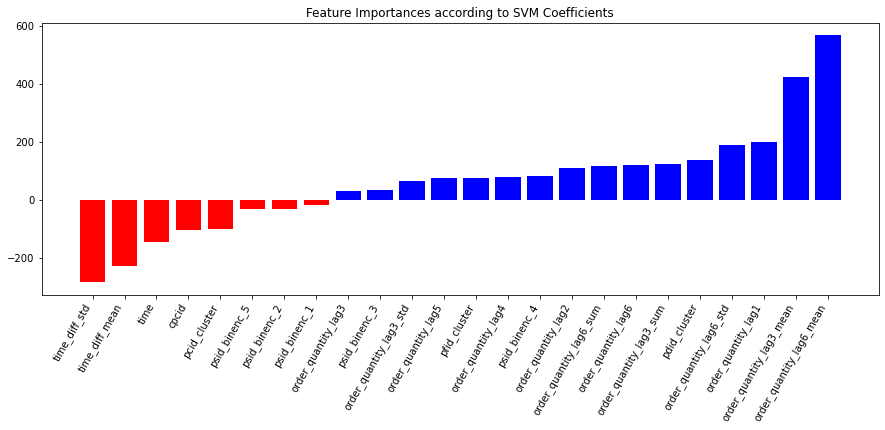

In [8]:
coef = svm.coef_
top_positive_features = []
top_negative_features = []

pnames, pcoef, nnames, ncoef = plot_coefficients(coef,feature_names,12)
top_positive_features.append((1,pnames,pcoef))
top_negative_features.append((1,nnames,ncoef))

In [9]:
importances_1 = pd.DataFrame([top_positive_features[0][1],top_positive_features[0][2]]).T
importances_1.columns = ['feature','coef_1_positive']
importances_positive = importances_1
importances_1 = pd.DataFrame([top_negative_features[0][1],top_negative_features[0][2]]).T
importances_1.columns = ['feature','coef_1_negative']
importances_negative = importances_1
importances = importances_positive.merge(importances_negative,how='outer',on='feature')
importances.set_index('feature',inplace=True)
importances['sum'] = importances.abs().sum(axis=1)
importances.sort_values('sum',ascending=False,inplace=True)
importances['rank'] = range(1,importances.shape[0]+1)
corr_matrix = train_x[importances.index.tolist()].corr().abs()

### 2.2.2. Dropping Highly Correlated Features

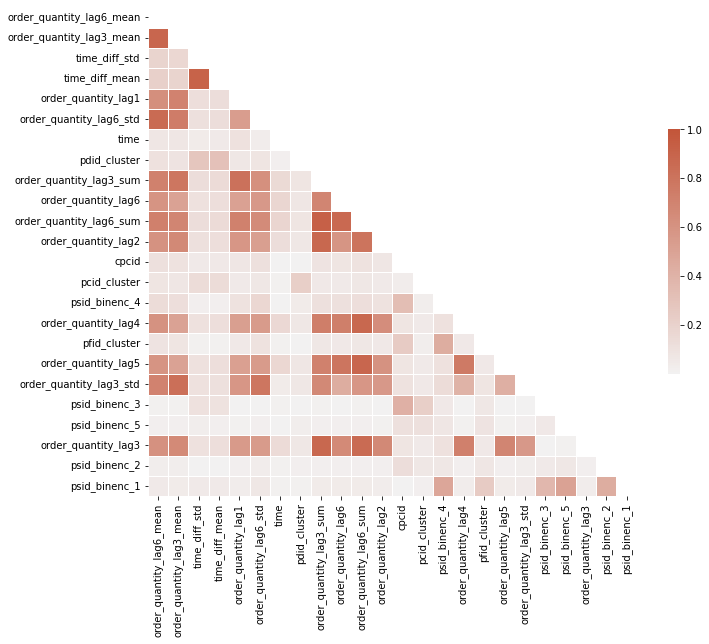

In [10]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0.0,
            square=True, linewidths=.6, cbar_kws={"shrink": .5});

In [11]:
importances

,coef_1_positive,coef_1_negative,sum,rank
feature,,,,
order_quantity_lag6_mean,568.040763,NaN,568.040763,1
order_quantity_lag3_mean,424.614037,NaN,424.614037,2
time_diff_std,NaN,-283.788874,283.788874,3
time_diff_mean,NaN,-226.788269,226.788269,4
order_quantity_lag1,201.59948,NaN,201.599480,5
order_quantity_lag6_std,190.112138,NaN,190.112138,6
time,NaN,-143.575803,143.575803,7
pdid_cluster,138.709195,NaN,138.709195,8
order_quantity_lag3_sum,124.670558,NaN,124.670558,9


In [12]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop=[]
for col in upper.columns:
    tmp = upper.loc[col]>0.90
    compare_with = tmp[tmp==True].index.tolist()
    current_rank = importances.loc[col]['rank']
    if(len(compare_with)==0):
        continue
    else:
        print('current col: '+col+' current rank: '+str(current_rank))
        win=0
        print('starting to compare with: '+str(compare_with))
        for col2 in compare_with:
            print('col2: '+ col2+' col2.rank: '+str(importances.loc[col2]['rank']))
            if current_rank < importances.loc[col2]['rank']:
                to_drop+=[col2]
print('to_drop: ')
print(set(to_drop))

current col: time_diff_std current rank: 3
starting to compare with: ['time_diff_mean']
col2: time_diff_mean col2.rank: 4
current col: order_quantity_lag3_sum current rank: 9
starting to compare with: ['order_quantity_lag6_sum']
col2: order_quantity_lag6_sum col2.rank: 11
to_drop: 
{'order_quantity_lag6_sum', 'time_diff_mean'}


/var/folders/tz/0rflsy9n69g5zgfg581qlnt40000gn/T/ipykernel_55831/3516798806.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [13]:
final_features = [e for e in feature_names if e not in set(to_drop)]

In [14]:
final_features

['order_quantity_lag1',
 'order_quantity_lag2',
 'order_quantity_lag3',
 'order_quantity_lag4',
 'order_quantity_lag5',
 'order_quantity_lag6',
 'order_quantity_lag3_mean',
 'order_quantity_lag3_std',
 'order_quantity_lag3_sum',
 'order_quantity_lag6_mean',
 'order_quantity_lag6_std',
 'pdid_cluster',
 'pfid_cluster',
 'pcid_cluster',
 'psid_binenc_1',
 'psid_binenc_2',
 'psid_binenc_3',
 'psid_binenc_4',
 'psid_binenc_5',
 'cpcid',
 'time',
 'time_diff_std']

## 2.3. Model Selection 

In [28]:
ix = {}
lag = 5
folds = 5
for fold in range(1,(1+folds)):
    train_till = (-1*lag*fold)
    valid_till = None if (-1*lag*(fold-1)) == 0 else (-1*lag*(fold-1))
    ix[fold] = {'train':df[df.period.isin(df.period.unique()[:train_till])].index,
                'valid':df[df.period.isin(df.period.unique()[train_till:valid_till])].index}

In [29]:
for k, v in ix.items():
    print(f"Fold: {k} ")
    print(f'Min-max train index: {v["train"].min(), v["train"].max()}, train.length: {len(v["train"])}')
    print(f'Min-max valid index: {v["valid"].min(), v["valid"].max()}, valid.length: {len(v["valid"])}')

Fold: 1 
Min-max train index: (0, 142058), train.length: 142059
Min-max valid index: (142059, 167058), valid.length: 25000
Fold: 2 
Min-max train index: (0, 117058), train.length: 117059
Min-max valid index: (117059, 142058), valid.length: 25000
Fold: 3 
Min-max train index: (0, 92108), train.length: 92109
Min-max valid index: (92109, 117058), valid.length: 24950
Fold: 4 
Min-max train index: (0, 67665), train.length: 67666
Min-max valid index: (67666, 92108), valid.length: 24443
Fold: 5 
Min-max train index: (0, 44216), train.length: 44217
Min-max valid index: (44217, 67665), valid.length: 23449


In [30]:
def run_kfold_model(df,model,model_name,final_features,fold_indexes,folds=[1,2,3]):
    results = {}
    for fold in tqdm(folds):
        print('='*5+' '+model_name+' - fold '+str(fold)+' '+'='*5)
        train = df.loc[fold_indexes[fold]['train']]
        valid = df.loc[fold_indexes[fold]['valid']]

        train_x = train[final_features]
        valid_x = valid[final_features]

        train_y = train['TARGET']
        valid_y = valid['TARGET']
        print('fitting model...')
        start_time = time.time()
        model.fit(train_x, train_y)
        ex_time = (time.time() - start_time)
        print('model fit!')
        train_y_pred = model.predict(train_x)
        print('predictions are made for train_x!')
        valid_y_pred = model.predict(valid_x)
        print('predictions are made for valid_x!')
        results[fold] = {}
        results[fold]['metrics']={
            'rmse_train':mean_squared_error(train_y,train_y_pred, squared=False),
            'mae_train':mean_absolute_error(train_y,train_y_pred),
            'rmse_valid':mean_squared_error(valid_y,valid_y_pred, squared=False),
            'mae_valid':mean_absolute_error(valid_y,valid_y_pred)
        }
        results[fold]['preds'] = {
            'train_y_pred': train_y_pred,
            'valid_y_pred': valid_y_pred
        }
        results[fold]['execution_time'] = ex_time
        pprint.pprint(results[fold])
    return results, model

### 2.3.1. K-Nearest Neighbor Regressor (KNN)

In [61]:
neighbors_list = [2,3,4,5,6,7,8,9,10,20]
# neighbors_list = [5]

In [62]:
cumulative_model_results_knn = {}
for neighbor in neighbors_list:
    knn = KNeighborsRegressor(
        n_neighbors=neighbor,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski')
    results, knn = run_kfold_model(df,knn,'K-Nearest Neighbor',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_knn[neighbor] = {'results':results,'model':knn}

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.01949310302734375,
 'metrics': {'mae_train': 2.5743458703778006,
             'mae_valid': 4.26936,
             'rmse_train': 4.818472127411493,
             'rmse_valid': 7.870447255397878},
 'preds': {'train_y_pred': array([ 6. , 12. , 13.5, ...,  4.5,  1.5,  3. ]),
           'valid_y_pred': array([ 1.5,  4.5, 18. , ...,  6. ,  1.5,  1.5])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.01739811897277832,
 'metrics': {'mae_train': 2.6454480219376553,
             'mae_valid': 4.1667,
             'rmse_train': 4.918099900019612,
             'rmse_valid': 7.675774228050223},
 'preds': {'train_y_pred': array([ 6. , 12. , 13.5, ...,  3. ,  0. , 12. ]),
           'valid_y_pred': array([0. , 1.5, 4.5, ..., 9. , 1.5, 6. ])

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.01789116859436035,
 'metrics': {'mae_train': 3.110242927234459,
             'mae_valid': 4.08984,
             'rmse_train': 5.572533159517526,
             'rmse_valid': 7.448199782497781},
 'preds': {'train_y_pred': array([ 6., 13., 13., ...,  4.,  1.,  6.]),
           'valid_y_pred': array([ 2.,  4., 22., ...,  6.,  2.,  9.])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.01602911949157715,
 'metrics': {'mae_train': 3.1831811308827174,
             'mae_valid': 4.00932,
             'rmse_train': 5.663024379325636,
             'rmse_valid': 7.182191865997455},
 'preds': {'train_y_pred': array([ 6., 13., 13., ...,  3.,  1.,  8.]),
           'valid_y_pred': array([ 2.,  4., 16., ..., 11.,  1.,  8.])}}
===== K-Nearest

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.013606786727905273,
 'metrics': {'mae_train': 3.364971596308576,
             'mae_valid': 3.9831,
             'rmse_train': 5.9306970489773345,
             'rmse_valid': 7.201512341168347},
 'preds': {'train_y_pred': array([ 5.25, 12.  , 12.75, ...,  6.  ,  0.75, 13.5 ]),
           'valid_y_pred': array([ 4.5 ,  3.75, 16.5 , ...,  7.5 ,  1.5 ,  7.5 ])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.014795064926147461,
 'metrics': {'mae_train': 3.4459289759864684,
             'mae_valid': 3.93558,
             'rmse_train': 6.040348724190523,
             'rmse_valid': 7.0205288262352425},
 'preds': {'train_y_pred': array([ 5.25, 12.  , 12.75, ...,  2.25,  0.75,  9.  ]),
           'valid_y_pred': array([ 2.25,  3.  , 

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.014842748641967773,
 'metrics': {'mae_train': 3.507477878909467,
             'mae_valid': 3.919632,
             'rmse_train': 6.140292138720709,
             'rmse_valid': 7.050073020898436},
 'preds': {'train_y_pred': array([ 4.8, 10.2, 12.6, ...,  5.4,  1.2, 10.8]),
           'valid_y_pred': array([ 4.2,  3. , 13.2, ...,  7.2,  1.8,  6. ])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.013595104217529297,
 'metrics': {'mae_train': 3.59046122041022,
             'mae_valid': 3.882288,
             'rmse_train': 6.250312103194095,
             'rmse_valid': 6.896217397965351},
 'preds': {'train_y_pred': array([ 4.8, 10.2, 12.6, ...,  1.8,  1.8,  9. ]),
           'valid_y_pred': array([ 1.8,  4.2, 10.8, ...,  7.2,  1.8

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.013904094696044922,
 'metrics': {'mae_train': 3.5977023631026546,
             'mae_valid': 3.87594,
             'rmse_train': 6.2682046798440085,
             'rmse_valid': 6.958177203837224},
 'preds': {'train_y_pred': array([ 6.5, 12. , 13.5, ...,  4.5,  1. , 10. ]),
           'valid_y_pred': array([ 3.5,  3.5, 11. , ...,  6. ,  2.5,  5. ])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.013860225677490234,
 'metrics': {'mae_train': 3.6815921885544896,
             'mae_valid': 3.8407,
             'rmse_train': 6.386059955963706,
             'rmse_valid': 6.811891807713919},
 'preds': {'train_y_pred': array([ 6.5, 12. , 13.5, ...,  2.5,  1.5,  8.5]),
           'valid_y_pred': array([1.5, 4.5, 9. , ..., 9. , 1.5, 8.

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.014077901840209961,
 'metrics': {'mae_train': 3.665068739045044,
             'mae_valid': 3.83772,
             'rmse_train': 6.363063229376575,
             'rmse_valid': 6.877979947867347},
 'preds': {'train_y_pred': array([ 6.        , 11.57142857, 14.14285714, ...,  3.85714286,
        0.85714286,  8.57142857]),
           'valid_y_pred': array([3.42857143, 3.85714286, 9.42857143, ..., 6.42857143, 3.        ,
       4.71428571])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.01752495765686035,
 'metrics': {'mae_train': 3.7481721671489225,
             'mae_valid': 3.8133771428571426,
             'rmse_train': 6.473095081801769,
             'rmse_valid': 6.760004286920509},
 'preds': {'train_y_pred': array([ 6.     

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.015198945999145508,
 'metrics': {'mae_train': 3.7114728739467404,
             'mae_valid': 3.809235,
             'rmse_train': 6.432678443307855,
             'rmse_valid': 6.837755799602674},
 'preds': {'train_y_pred': array([ 5.625, 11.625, 19.125, ...,  4.125,  0.75 ,  9.   ]),
           'valid_y_pred': array([3.   , 3.75 , 8.25 , ..., 7.125, 3.   , 6.375])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.015671968460083008,
 'metrics': {'mae_train': 3.795768586781025,
             'mae_valid': 3.796005,
             'rmse_train': 6.550782645179086,
             'rmse_valid': 6.720727778670998},
 'preds': {'train_y_pred': array([ 5.625, 11.625, 19.125, ...,  2.625,  1.875,  6.375]),
           'valid_y_pred': array([4

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.014232873916625977,
 'metrics': {'mae_train': 3.7487898220692335,
             'mae_valid': 3.7922400000000005,
             'rmse_train': 6.491494731760027,
             'rmse_valid': 6.815833200880302},
 'preds': {'train_y_pred': array([ 5.        , 11.        , 19.33333333, ...,  4.33333333,
        1.        ,  8.66666667]),
           'valid_y_pred': array([2.66666667, 3.66666667, 8.        , ..., 6.33333333, 3.        ,
       7.33333333])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.01416921615600586,
 'metrics': {'mae_train': 3.8350148215856965,
             'mae_valid': 3.7750266666666668,
             'rmse_train': 6.61063749072822,
             'rmse_valid': 6.685162010834974},
 'preds': {'train_y_pred': arra

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.015759944915771484,
 'metrics': {'mae_train': 3.7795366713830156,
             'mae_valid': 3.763992,
             'rmse_train': 6.539186850794914,
             'rmse_valid': 6.756661246503334},
 'preds': {'train_y_pred': array([ 6. , 12. , 18. , ...,  4.2,  0.9,  9. ]),
           'valid_y_pred': array([3.6, 3.9, 7.5, ..., 6.6, 2.7, 7.8])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.014821052551269531,
 'metrics': {'mae_train': 3.8660248250882034,
             'mae_valid': 3.7626,
             'rmse_train': 6.658145077498785,
             'rmse_valid': 6.6688098488410965},
 'preds': {'train_y_pred': array([ 6. , 12. , 18. , ...,  2.7,  1.5,  6. ]),
           'valid_y_pred': array([3.3, 4.2, 6.6, ..., 7.5, 0.9, 7.8])}}

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.014745950698852539,
 'metrics': {'mae_train': 3.9131089899267204,
             'mae_valid': 3.676062,
             'rmse_train': 6.74192918359683,
             'rmse_valid': 6.623611333706107},
 'preds': {'train_y_pred': array([ 6.75,  9.9 , 21.9 , ...,  4.65,  0.9 ,  8.1 ]),
           'valid_y_pred': array([4.8 , 4.35, 6.  , ..., 6.45, 2.1 , 9.15])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.015008926391601562,
 'metrics': {'mae_train': 4.004859942422198,
             'mae_valid': 3.6850020000000003,
             'rmse_train': 6.863009417520676,
             'rmse_valid': 6.542074693856682},
 'preds': {'train_y_pred': array([ 6.75,  9.9 , 21.9 , ...,  5.1 ,  2.1 ,  6.9 ]),
           'valid_y_pred': array([4.2 , 3.9 

# 2.3.2. Random Forest (RF)

In [64]:
estimators_list = [10,20,30,40,50,60,70,80,90,100]
# estimators_list = [100]

In [65]:
cumulative_model_results_rf = {}
for estimator in estimators_list:
    rf = RandomForestRegressor(
        n_estimators=estimator,
        criterion='mse',
        max_depth=7,
        min_samples_split=100,
        min_samples_leaf=40,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=45,
        min_impurity_decrease=0.0,
        bootstrap=True,);
    results, rf = run_kfold_model(df,rf,'Random Forest',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_rf[estimator] = {'results':results,'model':rf}

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 2.8232221603393555,
 'metrics': {'mae_train': 3.988509273490949,
             'mae_valid': 3.6224752410357546,
             'rmse_train': 6.803869899861267,
             'rmse_valid': 6.473800935827042},
 'preds': {'train_y_pred': array([ 6.92579979,  7.32813504, 11.00890059, ...,  5.91790289,
        1.6781367 ,  9.57816795]),
           'valid_y_pred': array([ 8.14045259,  4.93364419,  4.5349868 , ...,  5.33394078,
        1.6781367 , 10.94804266])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 2.7478480339050293,
 'metrics': {'mae_train': 4.06181965285665,
             'mae_valid': 3.636810267659228,
             'rmse_train': 6.898962148300741,
             'rmse_valid': 6.423713172905127},
 'preds': {'train_y_pred': array([ 7.3772

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 5.484838008880615,
 'metrics': {'mae_train': 3.9912051508741344,
             'mae_valid': 3.621268525830052,
             'rmse_train': 6.793639474598533,
             'rmse_valid': 6.463618620043533},
 'preds': {'train_y_pred': array([ 6.95340973,  7.14606741, 12.17465982, ...,  5.90839467,
        1.64955127,  9.49656319]),
           'valid_y_pred': array([ 8.1465843 ,  5.14605914,  4.72943569, ...,  5.40311574,
        1.64955127, 11.65107999])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 4.695404052734375,
 'metrics': {'mae_train': 4.056457658573901,
             'mae_valid': 3.6369767929889116,
             'rmse_train': 6.880959736959896,
             'rmse_valid': 6.4417008873295645},
 'preds': {'train_y_pred': array([ 7.245

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 8.8850839138031,
 'metrics': {'mae_train': 3.982007945972145,
             'mae_valid': 3.624640419200658,
             'rmse_train': 6.790429884285211,
             'rmse_valid': 6.46337771042777},
 'preds': {'train_y_pred': array([ 7.13006979,  7.59638551, 12.54313285, ...,  5.70548016,
        1.58449412, 10.03890627]),
           'valid_y_pred': array([ 7.91102999,  5.16387535,  5.15207892, ...,  5.45646505,
        1.58449412, 11.9003681 ])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 6.815500020980835,
 'metrics': {'mae_train': 4.064868575339051,
             'mae_valid': 3.641440736203193,
             'rmse_train': 6.880997514884683,
             'rmse_valid': 6.433164993053889},
 'preds': {'train_y_pred': array([ 7.29918557,

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 11.052726984024048,
 'metrics': {'mae_train': 3.9859155526470187,
             'mae_valid': 3.6173403288505472,
             'rmse_train': 6.79259913671942,
             'rmse_valid': 6.456910805147905},
 'preds': {'train_y_pred': array([ 6.90485213,  7.07447125, 13.08943402, ...,  5.68923564,
        1.66632095,  9.81991441]),
           'valid_y_pred': array([ 7.80941791,  4.98365165,  4.76733822, ...,  5.42250639,
        1.66632095, 11.67024347])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 9.186132907867432,
 'metrics': {'mae_train': 4.063488874614714,
             'mae_valid': 3.63778454480654,
             'rmse_train': 6.880136063097303,
             'rmse_valid': 6.421853649343642},
 'preds': {'train_y_pred': array([ 7.24268

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 13.327885150909424,
 'metrics': {'mae_train': 3.989540542358415,
             'mae_valid': 3.621626814180243,
             'rmse_train': 6.7939833241022525,
             'rmse_valid': 6.465061169851469},
 'preds': {'train_y_pred': array([ 7.19592231,  7.30406914, 12.69311149, ...,  5.74471182,
        1.6253968 , 10.07858687]),
           'valid_y_pred': array([ 8.24656752,  5.18561802,  5.21312559, ...,  5.36266796,
        1.6253968 , 11.59706973])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 10.897656202316284,
 'metrics': {'mae_train': 4.059969143614769,
             'mae_valid': 3.63972452437616,
             'rmse_train': 6.879844008568498,
             'rmse_valid': 6.4300204391834574},
 'preds': {'train_y_pred': array([ 7.224

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 17.141674995422363,
 'metrics': {'mae_train': 3.9881134145426524,
             'mae_valid': 3.6188025839190634,
             'rmse_train': 6.791151596843818,
             'rmse_valid': 6.462914688146757},
 'preds': {'train_y_pred': array([ 6.95978925,  7.0006825 , 12.85852146, ...,  5.64981445,
        1.62519446,  9.94233137]),
           'valid_y_pred': array([ 8.21664949,  5.11152672,  5.09735902, ...,  5.41392439,
        1.62519446, 11.66530881])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 15.621281147003174,
 'metrics': {'mae_train': 4.061700298769441,
             'mae_valid': 3.6399315683173046,
             'rmse_train': 6.87744036333965,
             'rmse_valid': 6.432434165025008},
 'preds': {'train_y_pred': array([ 7.21

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 19.467429876327515,
 'metrics': {'mae_train': 3.9855097042654117,
             'mae_valid': 3.6204073808364594,
             'rmse_train': 6.789696882961137,
             'rmse_valid': 6.463116375596595},
 'preds': {'train_y_pred': array([ 7.1287475 ,  7.25915353, 12.76741144, ...,  5.8638311 ,
        1.61866819,  9.81216546]),
           'valid_y_pred': array([ 7.94560244,  5.14691814,  4.97341238, ...,  5.37387984,
        1.61866819, 11.80725291])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 16.188979864120483,
 'metrics': {'mae_train': 4.061442950804163,
             'mae_valid': 3.641181701441353,
             'rmse_train': 6.875067112760581,
             'rmse_valid': 6.428070331263353},
 'preds': {'train_y_pred': array([ 7.25

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 22.478974103927612,
 'metrics': {'mae_train': 3.983771630979336,
             'mae_valid': 3.6191894835817098,
             'rmse_train': 6.788518224738511,
             'rmse_valid': 6.463717058224157},
 'preds': {'train_y_pred': array([ 7.03199763,  7.4422123 , 12.21265177, ...,  5.74029555,
        1.62774787,  9.40377112]),
           'valid_y_pred': array([ 7.96063217,  5.15190088,  4.92097845, ...,  5.44063387,
        1.62774787, 11.61364575])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 22.725421905517578,
 'metrics': {'mae_train': 4.06222913785526,
             'mae_valid': 3.6385432348047786,
             'rmse_train': 6.8801900995332215,
             'rmse_valid': 6.429335764569939},
 'preds': {'train_y_pred': array([ 7.17

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 27.902441024780273,
 'metrics': {'mae_train': 3.9841662588087283,
             'mae_valid': 3.61866453328877,
             'rmse_train': 6.787230759546407,
             'rmse_valid': 6.458278251920499},
 'preds': {'train_y_pred': array([ 7.10180959,  7.31052385, 12.59549029, ...,  5.88428385,
        1.61150254,  9.52003549]),
           'valid_y_pred': array([ 8.07956447,  5.00166017,  5.02249374, ...,  5.46115227,
        1.61150254, 11.49251166])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 23.870534896850586,
 'metrics': {'mae_train': 4.057848665214914,
             'mae_valid': 3.6357938042253064,
             'rmse_train': 6.875978095183757,
             'rmse_valid': 6.422580336434416},
 'preds': {'train_y_pred': array([ 7.166

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 30.170881986618042,
 'metrics': {'mae_train': 3.984479323016254,
             'mae_valid': 3.6171027944260663,
             'rmse_train': 6.790433123946524,
             'rmse_valid': 6.463199077148015},
 'preds': {'train_y_pred': array([ 7.10313074,  7.23048342, 13.17245193, ...,  5.85392194,
        1.63973856,  9.52322066]),
           'valid_y_pred': array([ 7.98511407,  5.09995395,  4.77540589, ...,  5.43326146,
        1.63973856, 11.74203951])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 28.37951898574829,
 'metrics': {'mae_train': 4.057570829052942,
             'mae_valid': 3.634180074781714,
             'rmse_train': 6.8742806682761906,
             'rmse_valid': 6.427443496631387},
 'preds': {'train_y_pred': array([ 7.247

### 2.3.3. Gradient Boosting (GB)

In [66]:
estimators_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# estimators_list = [1000]

In [67]:
cumulative_model_results_gb = {}
for estimator in estimators_list:
    gb = GradientBoostingRegressor(
        loss='ls',
        learning_rate=0.01,
        n_estimators=estimator,
        criterion='friedman_mse',
        min_samples_split=100,
        min_samples_leaf=40,
        min_weight_fraction_leaf=0.0,
        max_depth=7,
        min_impurity_decrease=0.0,
        alpha=0.9,
        verbose=0,
        max_leaf_nodes=45,
        n_iter_no_change=50,
        tol=0.0001,);
    results, gb = run_kfold_model(df,gb,'Gradient Boosting',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_gb[estimator] = {'results':results,'model':gb}

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 42.71660804748535,
 'metrics': {'mae_train': 4.188767689575713,
             'mae_valid': 3.787617529961701,
             'rmse_train': 7.135785355679893,
             'rmse_valid': 6.655618696328981},
 'preds': {'train_y_pred': array([ 6.59369952,  6.96312855, 13.50533781, ...,  5.70842395,
        2.87879676,  7.77821665]),
           'valid_y_pred': array([6.80209667, 4.94372003, 5.93020713, ..., 5.43312876, 2.87879676,
       9.03194463])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 33.307543992996216,
 'metrics': {'mae_train': 4.305372273425297,
             'mae_valid': 3.867393937791155,
             'rmse_train': 7.2521683046480625,
             'rmse_valid': 6.638982450032902},
 'preds': {'train_y_pred': array([ 6.63

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 83.28651523590088,
 'metrics': {'mae_train': 3.9624327033024382,
             'mae_valid': 3.622206444948474,
             'rmse_train': 6.694314276266599,
             'rmse_valid': 6.4546283484991545},
 'preds': {'train_y_pred': array([ 7.04271099,  7.58537644, 15.16043593, ...,  5.5612247 ,
        1.93317863,  8.31149467]),
           'valid_y_pred': array([6.66580959, 4.66312389, 5.0693369 , ..., 5.28761037, 1.93317863,
       9.38058165])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 65.46380519866943,
 'metrics': {'mae_train': 4.044985962325034,
             'mae_valid': 3.6453601841907135,
             'rmse_train': 6.77220282874336,
             'rmse_valid': 6.42937595731039},
 'preds': {'train_y_pred': array([ 7.039

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 127.882159948349,
 'metrics': {'mae_train': 3.8868747259419414,
             'mae_valid': 3.5797320333867026,
             'rmse_train': 6.5450426153133945,
             'rmse_valid': 6.42249359805575},
 'preds': {'train_y_pred': array([ 7.44975545,  8.33692939, 15.03778281, ...,  5.69393793,
        1.53629056,  8.16219873]),
           'valid_y_pred': array([6.56882754, 4.47397935, 4.73239436, ..., 5.29800519, 1.52958777,
       9.3703923 ])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 103.83837914466858,
 'metrics': {'mae_train': 3.9595154797887826,
             'mae_valid': 3.5720620464555624,
             'rmse_train': 6.60457585347585,
             'rmse_valid': 6.384962734828681},
 'preds': {'train_y_pred': array([ 7.4

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 163.83526802062988,
 'metrics': {'mae_train': 3.851657063591136,
             'mae_valid': 3.5704982298436585,
             'rmse_train': 6.458073787354091,
             'rmse_valid': 6.4058359906798685},
 'preds': {'train_y_pred': array([ 7.67276874,  8.60024835, 18.24964732, ...,  5.875387  ,
        1.40233318,  8.30884279]),
           'valid_y_pred': array([6.34207287, 4.35434637, 4.71617006, ..., 5.27348114, 1.3815675 ,
       9.51632366])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 142.1319718360901,
 'metrics': {'mae_train': 3.9185316491392315,
             'mae_valid': 3.5476495235927046,
             'rmse_train': 6.516987243406966,
             'rmse_valid': 6.362238398597063},
 'preds': {'train_y_pred': array([ 7

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 216.67699909210205,
 'metrics': {'mae_train': 3.825649929506492,
             'mae_valid': 3.567772713239807,
             'rmse_train': 6.392554407299014,
             'rmse_valid': 6.392677422316436},
 'preds': {'train_y_pred': array([ 7.90935747,  8.56244672, 18.61877472, ...,  5.71447373,
        1.36613124,  8.20142933]),
           'valid_y_pred': array([6.2441572 , 4.29385537, 4.87371068, ..., 5.1573845 , 1.36441477,
       9.30349449])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 178.21100211143494,
 'metrics': {'mae_train': 3.8930364211328365,
             'mae_valid': 3.538446901472873,
             'rmse_train': 6.459570073572881,
             'rmse_valid': 6.358844909042596},
 'preds': {'train_y_pred': array([ 7.7

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 266.4018437862396,
 'metrics': {'mae_train': 3.8094862239886114,
             'mae_valid': 3.5704601630286326,
             'rmse_train': 6.355900022422791,
             'rmse_valid': 6.421642538522572},
 'preds': {'train_y_pred': array([ 7.81666859,  8.80436301, 15.851411  , ...,  5.77887979,
        1.31183176,  8.54463538]),
           'valid_y_pred': array([6.41432065, 4.21899008, 4.72230481, ..., 5.34562829, 1.29488907,
       9.19762012])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 145.6247501373291,
 'metrics': {'mae_train': 3.912082624953064,
             'mae_valid': 3.5506882626239338,
             'rmse_train': 6.507263773486579,
             'rmse_valid': 6.376131574475619},
 'preds': {'train_y_pred': array([ 7.4

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 313.526997089386,
 'metrics': {'mae_train': 3.7896712862236646,
             'mae_valid': 3.574096753613434,
             'rmse_train': 6.28852024497403,
             'rmse_valid': 6.418716847710482},
 'preds': {'train_y_pred': array([ 8.1710321 ,  8.75566844, 17.65675534, ...,  5.75341018,
        1.33381723,  8.66026364]),
           'valid_y_pred': array([6.70606748, 4.2696865 , 5.25296931, ..., 5.17326682, 1.31286386,
       9.12658213])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 218.35137581825256,
 'metrics': {'mae_train': 3.876625762024332,
             'mae_valid': 3.5290839268804834,
             'rmse_train': 6.414803451331181,
             'rmse_valid': 6.359099052076248},
 'preds': {'train_y_pred': array([ 7.616

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 191.47439813613892,
 'metrics': {'mae_train': 3.8452759771528164,
             'mae_valid': 3.5703420907285284,
             'rmse_train': 6.435287712047976,
             'rmse_valid': 6.410190356134495},
 'preds': {'train_y_pred': array([ 7.52210201,  8.63534227, 15.15484288, ...,  5.6971332 ,
        1.39035562,  8.37856444]),
           'valid_y_pred': array([6.59414283, 4.32189   , 4.99146429, ..., 5.16272976, 1.35464582,
       9.11391464])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 124.65479302406311,
 'metrics': {'mae_train': 3.9292180357982653,
             'mae_valid': 3.5527705593021004,
             'rmse_train': 6.540895352646428,
             'rmse_valid': 6.369681198068355},
 'preds': {'train_y_pred': array([ 

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 242.5152130126953,
 'metrics': {'mae_train': 3.8169938551874067,
             'mae_valid': 3.5775427765360392,
             'rmse_train': 6.355315692597421,
             'rmse_valid': 6.419231082751018},
 'preds': {'train_y_pred': array([ 7.79866855,  8.47491504, 18.35866697, ...,  5.7362625 ,
        1.37018333,  8.27681085]),
           'valid_y_pred': array([6.29315491, 4.21747698, 5.17563169, ..., 5.18866897, 1.31852285,
       9.06259232])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 148.55619716644287,
 'metrics': {'mae_train': 3.916952685223976,
             'mae_valid': 3.5492582688944037,
             'rmse_train': 6.501962328080721,
             'rmse_valid': 6.363001615840589},
 'preds': {'train_y_pred': array([ 7.

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 225.2595009803772,
 'metrics': {'mae_train': 3.840793177324882,
             'mae_valid': 3.572684167823132,
             'rmse_train': 6.419781825924444,
             'rmse_valid': 6.417199675692789},
 'preds': {'train_y_pred': array([ 7.74433261,  8.51911172, 17.34184113, ...,  5.74156629,
        1.34096677,  8.22183822]),
           'valid_y_pred': array([6.62803084, 4.27702363, 4.78740726, ..., 5.27842932, 1.33583146,
       9.27730414])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 300.2773280143738,
 'metrics': {'mae_train': 3.861077484118081,
             'mae_valid': 3.535948913109007,
             'rmse_train': 6.3615573207900065,
             'rmse_valid': 6.35340524054244},
 'preds': {'train_y_pred': array([ 7.6246

# 3. Evaluation 

In [68]:
def get_metrics_from_results(dct):
    res = {}
    for key in dct.keys():
        tmp = dct[key]
        dfs = []
        for fold in tmp['results'].keys():
            dfs.append(pd.DataFrame.from_dict(tmp['results'][fold]['metrics'],orient='index',columns=['fold_'+str(fold)]))
        res[key] = pd.concat(dfs,axis=1)
    return res

## 3.1. Model Results

In [98]:
knn_results = get_metrics_from_results(cumulative_model_results_knn)[20]
knn_results['avg'] = knn_results.mean(axis=1)
knn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.741929,6.863009,7.010406,7.182826,7.392663,7.038167
mae_train,3.913109,4.004860,4.137003,4.274215,4.449929,4.155823
rmse_valid,6.623611,6.542075,6.630382,6.909603,7.162746,6.773683
mae_valid,3.676062,3.685002,3.695062,4.009700,4.311216,3.875408


In [76]:
rf_results = get_metrics_from_results(cumulative_model_results_rf)[100]
rf_results['avg'] = rf_results.mean(axis=1)
rf_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.790433,6.874281,6.997079,7.130805,7.274396,7.013399
mae_train,3.984479,4.057571,4.166363,4.291245,4.444998,4.188931
rmse_valid,6.463199,6.427443,6.501119,6.714780,6.966765,6.614661
mae_valid,3.617103,3.634180,3.724027,3.931205,4.197993,3.820902


In [99]:
gb_results = get_metrics_from_results(cumulative_model_results_gb)[1000]
gb_results['avg'] = gb_results.mean(axis=1)
gb_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.419782,6.361557,6.453020,6.669019,6.913725,6.563421
mae_train,3.840793,3.861077,3.961621,4.115870,4.299404,4.015753
rmse_valid,6.417200,6.353405,6.420797,6.688292,6.921599,6.560258
mae_valid,3.572684,3.535949,3.576028,3.856488,4.165910,3.741412


## 3.2. Error Rate with Parameter Changes

### 3.2.1. KNN

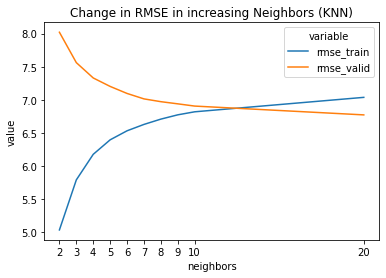

In [81]:
neighbors_list = [2,3,4,5,6,7,8,9,10,20]
x, y1, y2=[], [], []
for neighbor in neighbors_list:
    knn_results = get_metrics_from_results(cumulative_model_results_knn)[neighbor]
    knn_results['avg'] = knn_results.mean(axis=1)
    x.append(neighbor)
    y1.append(knn_results.loc['rmse_train'].avg)
    y2.append(knn_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['neighbors','rmse_train','rmse_valid']
re = re.melt(id_vars=['neighbors'])

fig = sns.lineplot(data=re,x='neighbors',y='value',hue='variable')
fig.set_xticks(neighbors_list);
fig.set_xticklabels(neighbors_list);
fig.set_title('Change in RMSE in increasing Neighbors (KNN)');

### 3.2.2. RF

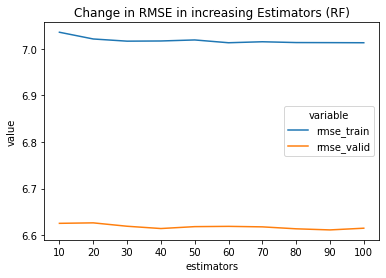

In [82]:
estimators_list = [10,20,30,40,50,60,70,80,90,100]
x, y1, y2=[], [], []
for estimator in estimators_list:
    rf_results = get_metrics_from_results(cumulative_model_results_rf)[estimator]
    rf_results['avg'] = rf_results.mean(axis=1)
    x.append(estimator)
    y1.append(rf_results.loc['rmse_train'].avg)
    y2.append(rf_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['estimators','rmse_train','rmse_valid']
re = re.melt(id_vars=['estimators'])

fig = sns.lineplot(data=re,x='estimators',y='value',hue='variable')
fig.set_xticks(estimators_list);
fig.set_xticklabels(estimators_list);
fig.set_title('Change in RMSE in increasing Estimators (RF)');

### 3.2.3. GB

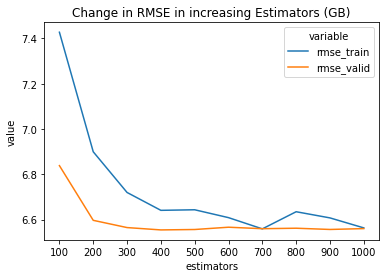

In [84]:
estimators_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
x, y1, y2=[], [], []
for estimator in estimators_list:
    gb_results = get_metrics_from_results(cumulative_model_results_gb)[estimator]
    gb_results['avg'] = gb_results.mean(axis=1)
    x.append(estimator)
    y1.append(gb_results.loc['rmse_train'].avg)
    y2.append(gb_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['estimators','rmse_train','rmse_valid']
re = re.melt(id_vars=['estimators'])

fig = sns.lineplot(data=re,x='estimators',y='value',hue='variable')
fig.set_xticks(estimators_list);
fig.set_xticklabels(estimators_list);
fig.set_title('Change in RMSE in increasing Estimators (GB)');

## 3.3. Error Rate in Total Monthly Orders

In [86]:
df['period_str'] = df.period.astype(str)
monthly_orders = pd.DataFrame(df.groupby('period_str').order_quantity.sum(),columns=['order_quantity']).reset_index()

In [87]:
def get_monthly_orders_from_results(dct):
    res = {}
    for key in dct.keys():
        tmp = dct[key]
        dfs = []
        for fold in tmp['results'].keys():
            r = np.hstack((tmp['results'][fold]['preds']['train_y_pred'],tmp['results'][fold]['preds']['valid_y_pred']))
            dfs.append(r)
        res[key] = pd.DataFrame(dfs).T
    return res

In [100]:
monthly_orders_knn = get_monthly_orders_from_results(cumulative_model_results_knn)[5]
monthly_orders_knn['avg'] = monthly_orders_knn.mean(axis=1)
monthly_orders_knn = pd.concat([df.period_str,monthly_orders_knn],axis=1)
monthly_orders_knn = pd.DataFrame(monthly_orders_knn.groupby('period_str')['avg'].sum()).reset_index().rename({'avg':'order_quantity_knn'},axis=1)

In [101]:
monthly_orders_rf = get_monthly_orders_from_results(cumulative_model_results_rf)[100]
monthly_orders_rf['avg'] = monthly_orders_rf.mean(axis=1)
monthly_orders_rf = pd.concat([df.period_str,monthly_orders_rf],axis=1)
monthly_orders_rf = pd.DataFrame(monthly_orders_rf.groupby('period_str')['avg'].sum()).reset_index().rename({'avg':'order_quantity_rf'},axis=1)

In [102]:
monthly_orders_gb = get_monthly_orders_from_results(cumulative_model_results_gb)[100]
monthly_orders_gb['avg'] = monthly_orders_gb.mean(axis=1)
monthly_orders_gb = pd.concat([df.period_str,monthly_orders_gb],axis=1)
monthly_orders_gb = pd.DataFrame(monthly_orders_gb.groupby('period_str')['avg'].sum()).reset_index().rename({'avg':'order_quantity_gb'},axis=1)

In [103]:
monthly_orders_per_model = monthly_orders.merge(monthly_orders_knn,on='period_str')
monthly_orders_per_model = monthly_orders_per_model.melt(id_vars=['period_str'])

In [104]:
monthly_orders_per_model = monthly_orders.merge(monthly_orders_knn,on='period_str').merge(monthly_orders_rf,on='period_str').merge(monthly_orders_gb,on='period_str')
monthly_orders_per_model = monthly_orders_per_model.melt(id_vars=['period_str'])

/var/folders/tz/0rflsy9n69g5zgfg581qlnt40000gn/T/ipykernel_55831/3008474350.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels=monthly_orders_per_model.period_str,rotation=45);


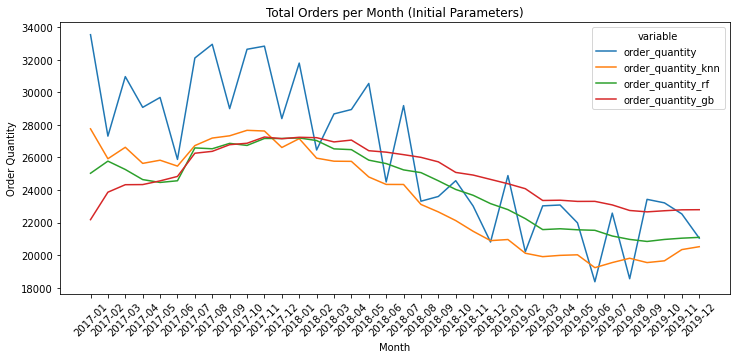

In [106]:
plt.figure(figsize=(12,5))
fig = sns.lineplot(data=monthly_orders_per_model,x='period_str',y='value',hue='variable')
fig.set_title('Total Orders per Month (Initial Parameters)')
fig.set_xlabel('Month')
fig.set_ylabel('Order Quantity')
fig.set_xticklabels(labels=monthly_orders_per_model.period_str,rotation=45);

# 4. Comparing with Previous Work

## 4.1. SVM

In [53]:
cumulative_model_results_svm = {}
tols = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00008,0.00009,0.00010]
for tol in tols:
    svm = LinearSVR(
              tol=tol,
              loss='squared_epsilon_insensitive',
              fit_intercept=True,
              intercept_scaling=1.0,
              dual=False,
              max_iter=100000)
    results, svm = run_kfold_model(df,svm,'SVM Regressor',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_svm[str(tol)] = {'results':results,'model':svm}

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.3526217937469482,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.223742961883545,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
             'rmse_train': 7.546723781488819,
             'rmse_valid': 6.803501807473085},
 'preds': {'train_y_pred': array([8.44645448, 8.51190

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.4213709831237793,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.1948199272155762,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
             'rmse_train': 7.546723781488819,
             'rmse_valid': 6.803501807473085},
 'preds': {'train_y_pred': array([8.44645448, 8.5119

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.4356369972229004,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.2273311614990234,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
             'rmse_train': 7.546723781488819,
             'rmse_valid': 6.803501807473085},
 'preds': {'train_y_pred': array([8.44645448, 8.5119

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.449641227722168,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.2945749759674072,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
             'rmse_train': 7.546723781488819,
             'rmse_valid': 6.803501807473085},
 'preds': {'train_y_pred': array([8.44645448, 8.51190

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.411125898361206,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.2167696952819824,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
             'rmse_train': 7.546723781488819,
             'rmse_valid': 6.803501807473085},
 'preds': {'train_y_pred': array([8.44645448, 8.51190

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.3735711574554443,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.22585129737854,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
             'rmse_train': 7.546723781488819,
             'rmse_valid': 6.803501807473085},
 'preds': {'train_y_pred': array([8.44645448, 8.511905

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.4851861000061035,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.286689043045044,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
             'rmse_train': 7.546723781488819,
             'rmse_valid': 6.803501807473085},
 'preds': {'train_y_pred': array([8.44645448, 8.51190

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.440026044845581,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.2148559093475342,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
             'rmse_train': 7.546723781488819,
             'rmse_valid': 6.803501807473085},
 'preds': {'train_y_pred': array([8.44645448, 8.51190

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.3085861206054688,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.979212760925293,
 'metrics': {'mae_train': 4.326881942124678,
             'mae_valid': 3.6359925622335063,
             'rmse_train': 7.5479706955546435,
             'rmse_valid': 6.8094086129324145},
 'preds': {'train_y_pred': array([8.39756305, 8.461

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 1.2992980480194092,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 0.9652140140533447,
 'metrics': {'mae_train': 4.326881942124678,
             'mae_valid': 3.6359925622335063,
             'rmse_train': 7.5479706955546435,
             'rmse_valid': 6.8094086129324145},
 'preds': {'train_y_pred': array([8.39756305, 8.46

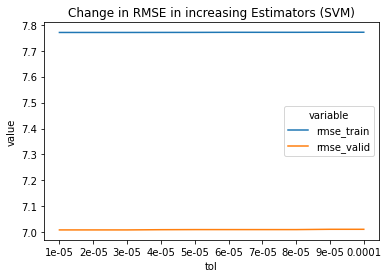

In [55]:
tols = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00008,0.00009,0.00010]
x, y1, y2=[], [], []
for tol in tols:
    svm_results = get_metrics_from_results(cumulative_model_results_svm)[str(tol)]
    svm_results['avg'] = svm_results.mean(axis=1)
    x.append(tol)
    y1.append(svm_results.loc['rmse_train'].avg)
    y2.append(svm_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['tol','rmse_train','rmse_valid']
re = re.melt(id_vars=['tol'])

fig = sns.lineplot(data=re,x='tol',y='value',hue='variable')
fig.set_xticks(tols);
fig.set_xticklabels(tols);
fig.set_title('Change in RMSE in increasing Estimators (SVM)');

In [56]:
svm_results = get_metrics_from_results(cumulative_model_results_svm)[str(0.00001)]
svm_results['avg'] = svm_results.mean(axis=1)
svm_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,7.416550,7.546724,7.743978,7.944773,8.200194,7.770444
mae_train,4.219605,4.327490,4.498295,4.663637,4.869179,4.515641
rmse_valid,6.768481,6.803502,6.787505,7.190507,7.494893,7.008978
mae_valid,3.610522,3.639753,3.691825,3.952011,4.202671,3.819357


## 4.2. MLP

In [57]:
from sklearn.neural_network import MLPRegressor

In [58]:
cumulative_model_results_mlp = {}
max_iters = [200,400,600,800,1000]
for max_iter in max_iters:
    mlp = MLPRegressor(
        hidden_layer_sizes=(100, ),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=max_iter,
        shuffle=True,
        momentum=0.9,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=10,
        max_fun=15000)
    results, mlp = run_kfold_model(df,mlp,'mlp Regressor',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_mlp[max_iter] = {'results':results,'model':mlp}

  0%|          | 0/5 [00:00<?, ?it/s]

===== mlp Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 61.3633599281311,
 'metrics': {'mae_train': 3.852870477760455,
             'mae_valid': 3.568023417736479,
             'rmse_train': 6.739252189655178,
             'rmse_valid': 6.593811076821141},
 'preds': {'train_y_pred': array([ 8.25788937, 10.11939095, 15.3652365 , ...,  4.7606998 ,
        1.40540978,  7.11477899]),
           'valid_y_pred': array([7.44629629, 4.46659943, 7.85672193, ..., 4.12364855, 1.38082774,
       8.16230699])}}
===== mlp Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 41.52627730369568,
 'metrics': {'mae_train': 4.0355817052401495,
             'mae_valid': 3.6374402628735076,
             'rmse_train': 6.930862830443077,
             'rmse_valid': 6.693984040320326},
 'preds': {'train_y_pred': array([ 8.22798775,  

  0%|          | 0/5 [00:00<?, ?it/s]

===== mlp Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 52.26441287994385,
 'metrics': {'mae_train': 3.9104582314704905,
             'mae_valid': 3.5985838680855986,
             'rmse_train': 6.757814601138458,
             'rmse_valid': 6.597388535926665},
 'preds': {'train_y_pred': array([ 9.17004516, 10.55652178, 16.41535164, ...,  4.82295419,
        1.98762331,  6.81127943]),
           'valid_y_pred': array([5.89418165, 4.27299562, 7.76556504, ..., 4.25830417, 1.83834573,
       7.21822559])}}
===== mlp Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 56.45461463928223,
 'metrics': {'mae_train': 3.9697339167634724,
             'mae_valid': 3.514391604336383,
             'rmse_train': 6.792045886561067,
             'rmse_valid': 6.524371932489392},
 'preds': {'train_y_pred': array([ 8.04911848,

  0%|          | 0/5 [00:00<?, ?it/s]

===== mlp Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 67.57885122299194,
 'metrics': {'mae_train': 3.9376777408254067,
             'mae_valid': 3.6717069061217393,
             'rmse_train': 6.744056900633162,
             'rmse_valid': 6.605638407794387},
 'preds': {'train_y_pred': array([ 8.15399432, 10.20196925, 14.99695171, ...,  4.45423146,
        2.03222482,  7.91073014]),
           'valid_y_pred': array([6.01932901, 5.89847248, 3.58881068, ..., 4.30823856, 1.27143282,
       8.59302891])}}
===== mlp Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 59.504127979278564,
 'metrics': {'mae_train': 3.982227206791974,
             'mae_valid': 3.509387446362052,
             'rmse_train': 6.809450274683161,
             'rmse_valid': 6.597625798522798},
 'preds': {'train_y_pred': array([ 8.45352821,

  0%|          | 0/5 [00:00<?, ?it/s]

===== mlp Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 48.098089933395386,
 'metrics': {'mae_train': 4.012029992846995,
             'mae_valid': 3.6840334832195483,
             'rmse_train': 6.897783062253239,
             'rmse_valid': 6.570202198604281},
 'preds': {'train_y_pred': array([ 8.7254007 , 10.73681583, 17.4841499 , ...,  5.45675418,
        2.32177345,  7.61189689]),
           'valid_y_pred': array([7.06919903, 5.29276632, 7.35633814, ..., 5.70025357, 2.25848256,
       9.43670482])}}
===== mlp Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 42.797701835632324,
 'metrics': {'mae_train': 3.975949865440885,
             'mae_valid': 3.543613848552232,
             'rmse_train': 6.815421917252942,
             'rmse_valid': 6.555007711004484},
 'preds': {'train_y_pred': array([ 7.26167195,

  0%|          | 0/5 [00:00<?, ?it/s]

===== mlp Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 44.62195301055908,
 'metrics': {'mae_train': 3.9090868021933227,
             'mae_valid': 3.642027017937815,
             'rmse_train': 6.780257168374898,
             'rmse_valid': 6.596673958400801},
 'preds': {'train_y_pred': array([ 7.90357844,  9.48127917, 16.58674294, ...,  5.43338618,
        2.59051097,  8.54411729]),
           'valid_y_pred': array([6.56174862, 4.32615531, 8.14664931, ..., 4.8308102 , 0.7067311 ,
       7.85427068])}}
===== mlp Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
{'execution_time': 53.86970400810242,
 'metrics': {'mae_train': 3.987551971244915,
             'mae_valid': 3.523366783511312,
             'rmse_train': 6.81931086151311,
             'rmse_valid': 6.490479519743879},
 'preds': {'train_y_pred': array([ 8.21312612, 10

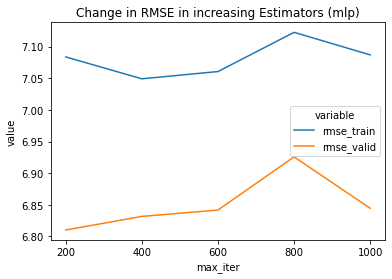

In [59]:
max_iters = [200,400,600,800,1000]
x, y1, y2=[], [], []
for max_iter in max_iters:
    mlp_results = get_metrics_from_results(cumulative_model_results_mlp)[max_iter]
    mlp_results['avg'] = mlp_results.mean(axis=1)
    x.append(max_iter)
    y1.append(mlp_results.loc['rmse_train'].avg)
    y2.append(mlp_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['max_iter','rmse_train','rmse_valid']
re = re.melt(id_vars=['max_iter'])

fig = sns.lineplot(data=re,x='max_iter',y='value',hue='variable')
fig.set_xticks(max_iters);
fig.set_xticklabels(max_iters);
fig.set_title('Change in RMSE in increasing Estimators (mlp)');

In [60]:
mlp_results = get_metrics_from_results(cumulative_model_results_mlp)[200]
mlp_results['avg'] = mlp_results.mean(axis=1)
mlp_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.739252,6.930863,7.035137,7.304298,7.409231,7.083756
mae_train,3.852870,4.035582,4.188096,4.338786,4.359530,4.154973
rmse_valid,6.593811,6.693984,6.602706,6.942484,7.218114,6.810220
mae_valid,3.568023,3.637440,3.628372,3.926752,4.183883,3.788894
